# **Project: Annual Water Usage in Baltimore**

## **Problem Description**

> The problem is to predict annual water usage. The dataset provides the annual water usage
in Baltimore from 1885 to 1963, or 79 years of data. The values are in the units of liters per
capita per day, and there are 79 observations. The dataset is credited to Hipel and McLeod,
1994.

## **Test Harness**


### **Validation Dataset**

> The dataset is not current. This means that we cannot easily collect updated data to validate
the model. Therefore, we will pretend that it is 1953 and withhold the last 10 years of data
from analysis and model selection. This final decade of data will be used to validate the final
model. 

In [2]:
# separate out a validation dataset
from pandas import read_csv
series = read_csv('water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


**The specific contents of these files are:**
>
* dataset.csv: Observations from 1885 to 1953 (69 observations).
* validation.csv: Observations from 1954 to 1963 (10 observations).

### **Model Evaluation**

> The RMSE performance measure and walk-forward validation will be used for model evaluation

## **Persistence**

The first step before getting bogged down in data analysis and modeling is to establish a baseline
of performance. This will provide both a template for evaluating models using the proposed
test harness and a performance measure by which all more elaborate predictive models can be
compared.

In [3]:
# evaluate a persistence model
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)


>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

## **Data Analysis**

We can use summary statistics and plots of the data to quickly learn more about the structure
of the prediction problem.

### **Summary Statistics**

In [4]:
# summary statistics of time series
print(series.describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64


**Some observations from these statistics include:**
> 


*   The number of observations (count) matches our expectation, meaning we are handling
the data correctly.
*   The mean is about 500, which we might consider our level in this series.
*    The standard deviation and percentiles suggest a reasonably tight spread around the
mean



### **Line Plot**

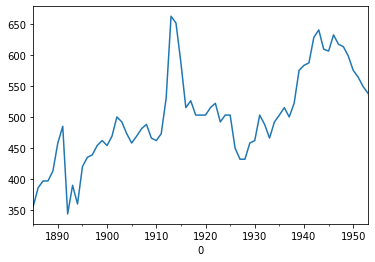

In [5]:
# line plot of time series
series.plot()
pyplot.show()


**Some observations from the plot include:**
>


*   There looks to be an increasing trend in water usage over time.
*   There do not appear to be any obvious outliers, although there are some large fluctuations.
*   There is a downward trend for the last few years of the series.



### **Density Plot**

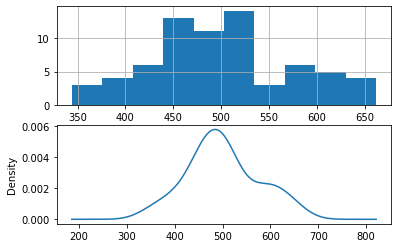

In [6]:
# density plots of time series
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

** Some observations from the plots include:**
>


*    The distribution is not Gaussian, but is pretty close.
*   The distribution has a long right tail and may suggest an exponential distribution or a
double Gaussian.




### **Box and Whisker Plots**

> We can group the annual data by decade and get an idea of the spread of observations for each
decade and how this may be changing. We do expect to see some trend (increasing mean or
median), but it may be interesting to see how the rest of the distribution may be changing. The
example below groups the observations by decade and creates one box and whisker plot for
each decade of observations. The last decade only contains 9 years and may not be a useful
comparison with the other decades. Therefore only data between 1885 and 1944 was plotted.

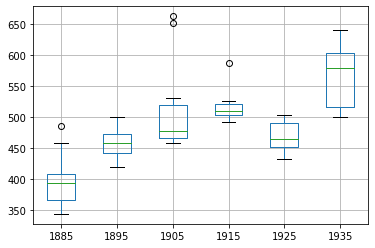

In [7]:
# boxplots of time series
from pandas import DataFrame
from pandas import Grouper
groups = series.groupby(Grouper(freq='10YS'))
decades = DataFrame()
for name, group in groups:
    if len(group.values) is 10:
        decades[name.year] = group.values
decades.boxplot()
pyplot.show()


**Some observations from reviewing the plot include:**
>
*    The median values for each year (red line) may show an increasing trend that may not be
linear.
*    The spread, or middle 50% of the data (blue boxes), does show some variability.
*    There maybe outliers in some decades (crosses outside of the box and whiskers).
*    The second to last decade seems to have a lower average consumption, perhaps related to
the first world war.


## **Modelling**


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


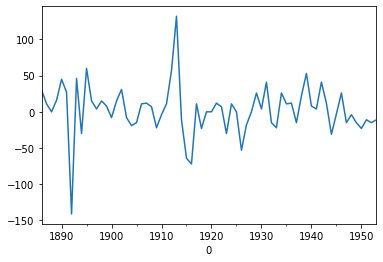

In [8]:
# create and summarize a stationary version of the time series
from pandas import Series
from statsmodels.tsa.stattools import adfuller
# create a differenced series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv', header=False)

The result of a statistical significance test of whether the
differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show
that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This
suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a
low probability that the result is a statistical fluke).

This suggests that at least one level of differencing is required. 

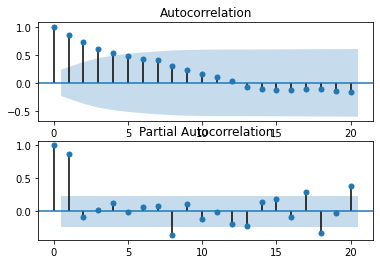

In [9]:
# ACF and PACF plots of the time series
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=20, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=20, ax=pyplot.gca())
pyplot.show()

**some observations from the plots.**
>
* The ACF shows significant lags to 4 time steps.
* The PACF shows significant lags to 1 time step.

In [10]:
# evaluate a manually configured ARIMA model
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=548.319, Expected=503.000
>Predicted=545.085, Expected=503.000
>Predicted=546.061, Expected=515.000
>Predicted=550.660, Expected=522.000
>Predicted=552.011, Expected=492.000
>Predicted=519.221, Expected=503.000
>Predicted=527.953, Expected=503.000
>Predicted=534.026, Expected=450.000
>Predicted=474.119, Expected=432.000
>Predicted=456.458, Expected=432.000
>Predicted=465.408, Expected=458.000
>Predicted=481.425, Expected=462.000
>Predicted=476.154, Expected=503.000
>Predicted=511.083, Expected=488.000
>Predicted=497.183, Expected=466.000
>Predicted=460.301, Expected=492.000
>Predicted=506.310, Expected=503.000
>Predicted=515.928, Expected=515.000
>Predicted=516.368, Expected=500.000
>Predicted=504.364, Expected=522.000
>Predicted=525.885, Expected=575.000
>Predicted=579.358, Expected=583.000
>Predicted=575.313, Expected=587.000
>Predicted=573.357, Expected=628.000
>Predicted=622.136, Expected=640.000
>Predicted=632.299, Expected=609.000
>Predicted=595.782, Expected=606.000
>

In [11]:
# grid search ARIMA parameters for a time series
import warnings
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=282.656
ARIMA(0, 0, 4) RMSE=77.295
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(0, 1, 2) RMSE=22.182
ARIMA(0, 1, 3) RMSE=24.733
ARIMA(0, 1, 4) RMSE=24.845
ARIMA(0, 2, 1) RMSE=22.381
ARIMA(0, 2, 2) RMSE=22.244
ARIMA(1, 0, 0) RMSE=22.084
ARIMA(1, 1, 0) RMSE=21.922
ARIMA(1, 2, 0) RMSE=27.464
ARIMA(1, 2, 1) RMSE=22.271
ARIMA(2, 0, 0) RMSE=22.793
ARIMA(2, 1, 0) RMSE=21.733
ARIMA(2, 2, 0) RMSE=25.282
ARIMA(3, 0, 0) RMSE=21.962
ARIMA(3, 1, 0) RMSE=24.270
ARIMA(3, 1, 1) RMSE=25.491
ARIMA(3, 2, 0) RMSE=25.625
ARIMA(3, 2, 1) RMSE=25.007
ARIMA(3, 2, 4) RMSE=25.966
ARIMA(4, 0, 0) RMSE=24.923
ARIMA(4, 1, 0) RMSE=24.802
ARIMA(4, 1, 1) RMSE=25.103
ARIMA(4, 1, 2) RMSE=24.995
ARIMA(4, 2, 0) RMSE=27.089
ARIMA(4, 2, 1) RMSE=25.933
ARIMA(4, 2, 2) RMSE=25.419
Best ARIMA(2, 1, 0) RMSE=21.733


The results show that the best configuration discovered was ARIMA(2,1,0) with an RMSE
of 21.733, slightly lower than the persistence model tested earlier, but may or may not be significantly different.

               0
count  35.000000
mean    1.081625
std    22.022566
min   -52.103811
25%   -16.202280
50%    -0.459805
75%    12.085093
max    51.284333


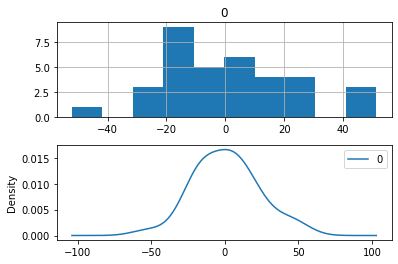

In [13]:
# summarize residual errors for an ARIMA model
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
# predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

We can see that the
distribution has a right shift and that the mean is non-zero at 1.081624. This is perhaps a sign
that the predictions are biased.


RMSE: 21.706
                  0
count  3.500000e+01
mean   6.256219e-07
std    2.202257e+01
min   -5.318544e+01
25%   -1.728390e+01
50%   -1.541429e+00
75%    1.100347e+01
max    5.020271e+01


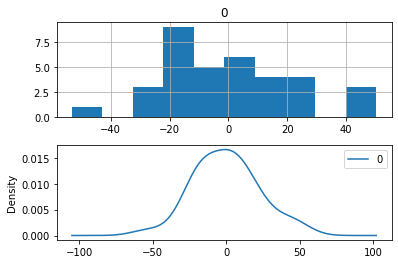

In [14]:
# summarize residual errors from bias corrected forecasts

from statsmodels.tsa.arima_model import ARIMA
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
# predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()


The performance of the predictions is improved very slightly from 21.733 to 21.706, which
may or may not be significant. The summary of the forecast residual errors shows that the
mean was indeed moved to a value very close to zero.


## **Model Validation**


In [16]:
# save finalized model to file
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 1.081624
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes
the coefficients and all other internal data returned when fitting the model.
* model bias.npy This is the bias value stored as a one-row, one-column NumPy array

In [17]:
# load finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults
import numpy
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)


Predicted: 540.013


the prediction of about 540

>Predicted=540.013, Expected=568.000
>Predicted=571.589, Expected=575.000
>Predicted=573.289, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.063, Expected=602.000
>Predicted=603.022, Expected=594.000
>Predicted=593.178, Expected=587.000
>Predicted=588.558, Expected=587.000
>Predicted=588.797, Expected=625.000
>Predicted=627.941, Expected=613.000
RMSE: 16.532


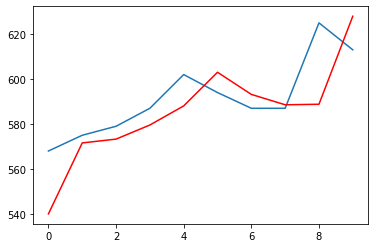

In [18]:
# load and evaluate the finalized model on the validation dataset
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True,
squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()


The final RMSE for the validation period is predicted at 16 liters per capita
per day. This is not too different from the expected error of 21, but We would expect that it is
also not too different from a simple persistence model.

A plot of the predictions compared to the validation dataset is also provided. The forecast
does have the characteristics of a persistence forecast. This suggests that although this time
series does have an obvious trend, it is still a reasonably difficult problem.